In [2]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensemble modeli için yükleme
mlp_model = load_model("models_daily/mlp_model_tuned.keras")
lgbm_model = joblib.load("models_daily/lgbm_model.pkl")
rf_model   = joblib.load("models_daily/rf_model.pkl")
ensemble_weights = joblib.load("models_daily/ensemble_weights.pkl")

# Scalerlar
scaler = joblib.load("models_daily/scaler.pkl")
y_scaler = joblib.load("models_daily/y_scaler.pkl")


In [3]:
X_test = joblib.load("models_daily/X_test.pkl")
X_test_scaled = joblib.load("models_daily/X_test_scaled.pkl")
y_test = joblib.load("models_daily/y_test.pkl")

y_true = y_test.values.reshape(-1)

In [4]:
# MLP scaled
mlp_preds_scaled = mlp_model.predict(X_test_scaled).reshape(-1)
mlp_preds = y_scaler.inverse_transform(mlp_preds_scaled.reshape(-1, 1)).reshape(-1)

# Tree modeller
lgbm_preds = lgbm_model.predict(X_test).reshape(-1)
rf_preds   = rf_model.predict(X_test).reshape(-1)

170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [5]:
w1, w2, w3 = ensemble_weights

ensemble_preds = w1 * mlp_preds + w2 * lgbm_preds + w3 * rf_preds


In [6]:
def evaluate_model(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    
    print(f"\n{name} Test Performansı:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"SMAPE: {smape:.2f}%")
    print(f"Corr : {corr:.4f}")


In [7]:
evaluate_model(y_true, mlp_preds, name="MLP")
evaluate_model(y_true, lgbm_preds, name="LightGBM")
evaluate_model(y_true, rf_preds, name="Random Forest")
evaluate_model(y_true, ensemble_preds, name="Ensemble")



MLP Test Performansı:
MAE  : 4.26
RMSE : 5.19
R²   : -0.0314
MAPE : 6.14%
SMAPE: 6.38%
Corr : 0.6949

LightGBM Test Performansı:
MAE  : 3.09
RMSE : 3.76
R²   : 0.4585
MAPE : 4.45%
SMAPE: 4.58%
Corr : 0.8309

Random Forest Test Performansı:
MAE  : 4.17
RMSE : 4.94
R²   : 0.0683
MAPE : 5.94%
SMAPE: 6.18%
Corr : 0.7876

Ensemble Test Performansı:
MAE  : 3.09
RMSE : 3.76
R²   : 0.4585
MAPE : 4.45%
SMAPE: 4.58%
Corr : 0.8309


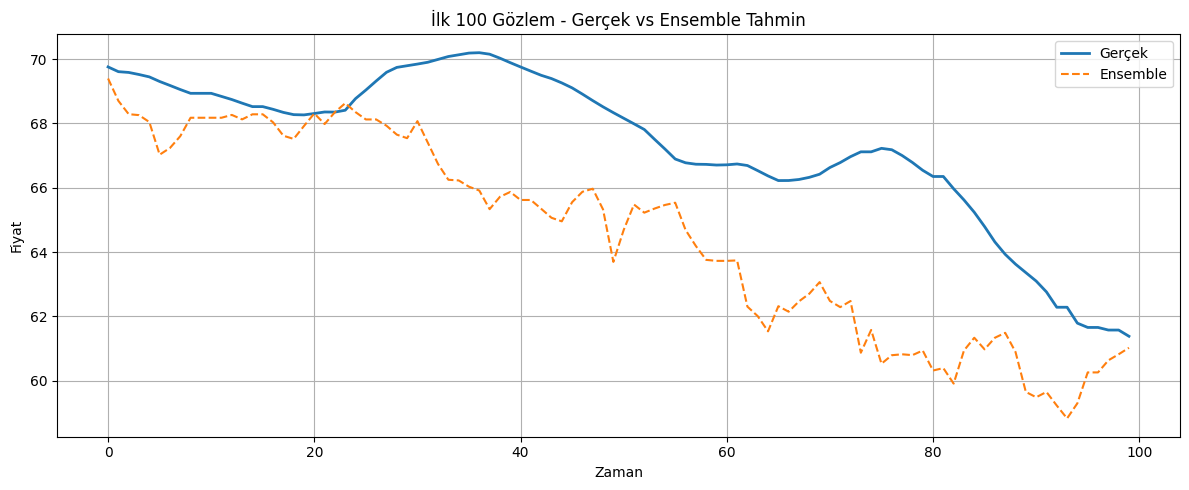

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_true[:100], label="Gerçek", linewidth=2)
plt.plot(ensemble_preds[:100], label="Ensemble", linestyle="--")
plt.title("İlk 100 Gözlem - Gerçek vs Ensemble Tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


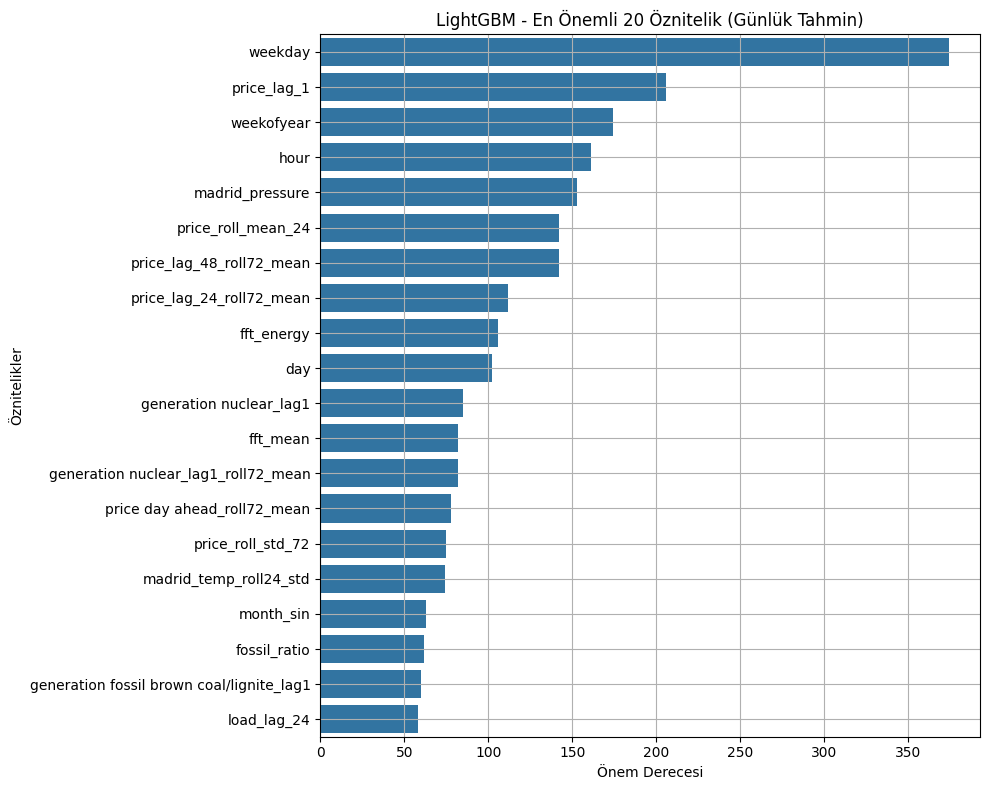

En Önemli 10 Öznitelik:
                    feature  importance
0                   weekday         374
1               price_lag_1         206
2                weekofyear         174
3                      hour         161
4           madrid_pressure         153
5        price_roll_mean_24         142
6  price_lag_48_roll72_mean         142
7  price_lag_24_roll72_mean         112
8                fft_energy         106
9                       day         102


In [10]:
import seaborn as sns

# Öznitelik Önemi Analizi
feature_importances = pd.DataFrame({'feature': X_test.columns, 'importance': lgbm_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

# En önemli 20 özniteliği gösterme
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=feature_importances.head(20))
plt.title('LightGBM - En Önemli 20 Öznitelik (Günlük Tahmin)')
plt.xlabel('Önem Derecesi')
plt.ylabel('Öznitelikler')
plt.grid(True)
plt.tight_layout()
plt.show()

print("En Önemli 10 Öznitelik:")
print(feature_importances.head(10))

SHAP Summary Plot:


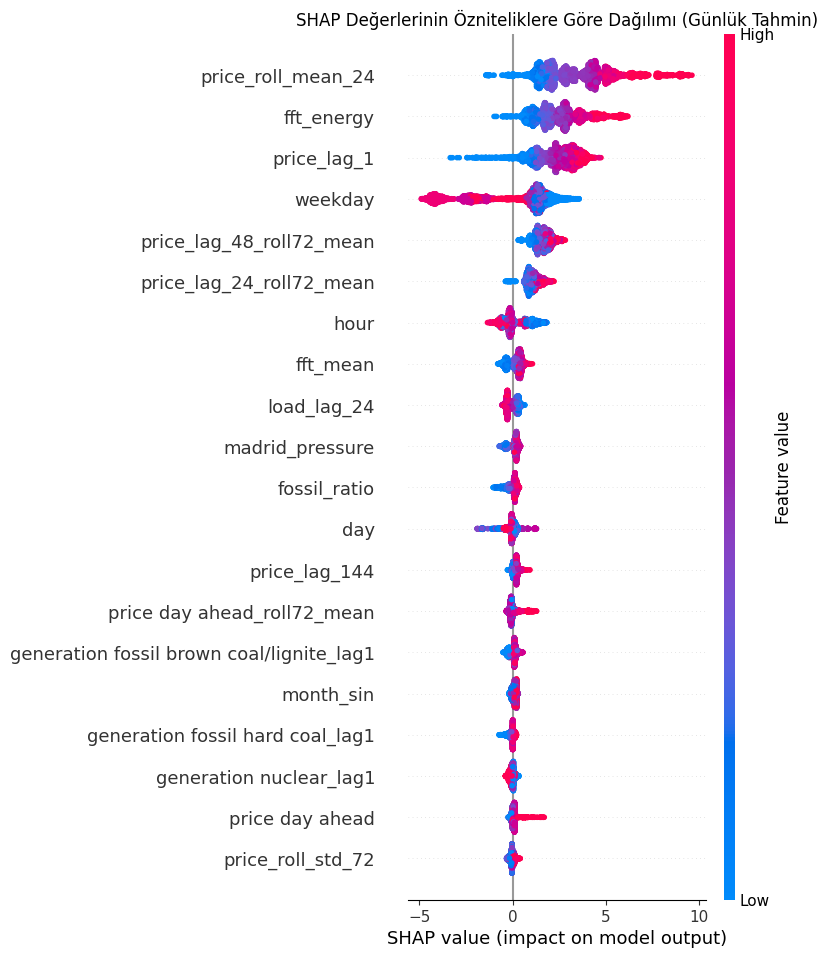


En Önemli Öznitelik için Bağımlılık Grafiği: 'weekday'


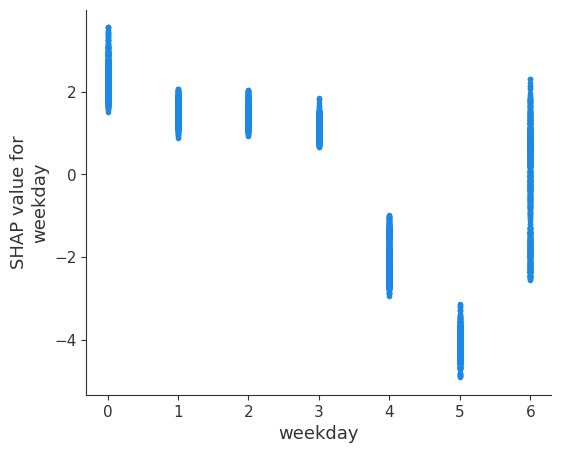


Tek Bir Tahmin için Force Plot (İlk Gözlem):


In [11]:
import shap

# LightGBM modeli için bir TreeExplainer oluşturuyoruz. Bu, ağaç tabanlı modeller için en verimli yöntemdir.
explainer = shap.TreeExplainer(lgbm_model)

# Test seti üzerindeki SHAP değerlerini hesaplıyoruz.
# Not: Veri seti büyükse bu işlem biraz zaman alabilir.
shap_values = explainer.shap_values(X_test)

# --- Görselleştirmeler ve Yorumlar ---

# 1. SHAP Summary Plot (Beeswarm Plot)
# Bu grafik, en önemli öznitelikleri ve bu özniteliklerin tahminler üzerindeki etkisini özetler.
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Değerlerinin Özniteliklere Göre Dağılımı (Günlük Tahmin)")
plt.show()


# 2. En Önemli Öznitelik İçin Dependence Plot
# Bu grafik, tek bir özniteliğin değerindeki değişimin, tahmin üzerindeki etkisini (SHAP değerini) nasıl değiştirdiğini gösterir.
# Önceki analizden en önemli özniteliğin adını alalım (örneğin: 'price_lag_24')
most_important_feature = feature_importances.feature[0]
print(f"\nEn Önemli Öznitelik için Bağımlılık Grafiği: '{most_important_feature}'")
shap.dependence_plot(most_important_feature, shap_values, X_test, interaction_index=None)


# 3. Tek bir tahmin için Force Plot
# Bu grafik, test setindeki ilk gözlem için yapılan tahminin nasıl oluştuğunu açıklar.
print("\nTek Bir Tahmin için Force Plot (İlk Gözlem):")
shap.initjs() # Javascript'i notebook'ta başlatır
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

Test setinde yapılan değerlendirmelerde LightGBM modeli en düşük hata oranlarına ulaşmış ve diğer modellere göre çok daha tutarlı sonuçlar üretmiştir. Ensemble modeli kurulmuş olsa da, ağırlık optimizasyonu sonucunda sadece LightGBM modeline ağırlık verilmiş (diğer modellerin ağırlıkları sıfır kalmıştır).

Bu durum, LightGBM’in veri yapısıyla en iyi uyumu yakaladığını ve tahmin doğruluğu açısından öne çıktığını gösteriyor. Model sadece düşük hata üretmekle kalmamış, aynı zamanda günlük bazda değişimleri de başarılı şekilde takip edebilmiştir.

Sonuç olarak, bu günlük tahmin probleminde LightGBM modeli en güvenilir seçenek olarak öne çıkmış ve final tahminler için tercih edilmiştir.